<a href="https://colab.research.google.com/github/eriksali/DNN_2023_DL/blob/main/DNN_a4_pass_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 2
# train a RNN to perform time series prediction. The task is to build a model for predicting S&P index for day “t” using the closing prices of Dow Jones index and Nasdaq for day “t-1”.  You can use training data for any 6 months period and test the performance for the following one-month period. Yahoo Finance is an excellent source for data for this project.
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(out[:, -1, :])
        return out, h

# Download data from Yahoo Finance
start_date = '2021-01-01'
end_date = '2021-06-30'
tickers = ['^GSPC', '^DJI', '^IXIC']
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
df = df.dropna()
print(df.head())

# Prepare the data for training
X = np.array(df.iloc[:-1, [1, 2]])
Y = np.array(df.iloc[1:, 0])
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
Y = np.reshape(Y, (Y.shape[0], 1, 1))
train_size = int(0.8 * len(X))
train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

# Train the RNN model
input_size = 2
hidden_size = 16
output_size = 1
rnn = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

num_epochs = 1000
batch_size = 32
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Training phase
    rnn.train()
    hidden = torch.zeros(1, batch_size, hidden_size)
    for i in range(0, train_X.shape[0], batch_size):
        batch_X = torch.tensor(train_X[i:i+batch_size])
        batch_Y = torch.tensor(train_Y[i:i+batch_size])
        optimizer.zero_grad()
        output, hidden = rnn(batch_X, hidden)
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Evaluation phase
    rnn.eval()
    hidden = torch.zeros(1, 1, hidden_size)
    with torch.no_grad():
        test_output, _ = rnn(torch.tensor(test_X), hidden)
        test_loss = criterion(test_output, torch.tensor(test_Y))
        test_losses.append(test_loss.item())

    # Print the training progress
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses):.4f}, Test Loss: {test_loss.item():.4f}')

# Make predictions for the test set
rnn.eval()
hidden = torch.zeros(1, 1, hidden_size)
with torch.no_grad():
    test_output, _ = rnn(torch.tensor(test_X), hidden)
test_predictions = test_output.numpy().squeeze()

# Plot the results
import matplotlib.pyplot as plt
plt.plot(df.index[train_size+1:], df.iloc[train_size+1:, 0])
plt.plot(df.index[train_size+1:], test_predictions)
plt.legend(['Actual', 'Predicted'])
plt.show()


[*********************100%***********************]  3 of 3 completed
Epoch [1/1000], Train Loss: 1.1798, Test Loss: 1177124992.0000
Epoch [101/1000], Train Loss: 0.4109, Test Loss: 1177032320.0000
Epoch [201/1000], Train Loss: 0.2231, Test Loss: 1177036672.0000
Epoch [301/1000], Train Loss: 0.1574, Test Loss: 1177039232.0000
Epoch [401/1000], Train Loss: 0.1240, Test Loss: 1177040896.0000
Epoch [501/1000], Train Loss: 0.1038, Test Loss: 1177041792.0000
Epoch [601/1000], Train Loss: 0.0901, Test Loss: 1177042560.0000
Epoch [701/1000], Train Loss: 0.0803, Test Loss: 1177042944.0000
Epoch [801/1000], Train Loss: 0.0728, Test Loss: 1177042944.0000
Epoch [901/1000], Train Loss: 0.0670, Test Loss: 1177043456.0000


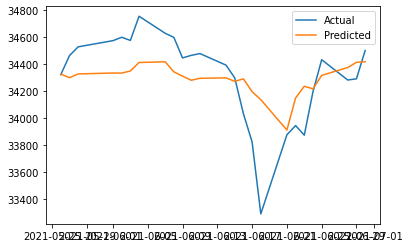

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf

# Define the model
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Download data from Yahoo Finance
start_date = '2021-01-01'
end_date = '2021-07-01'
tickers = ['^GSPC', '^DJI', '^IXIC']
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
df = df.dropna()

# Prepare the data for training and testing
X = np.array(df.iloc[:-1, [1, 2]])
Y = np.array(df.iloc[1:, 0])
train_size = int(0.8 * len(X))
train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

# Normalize the data
train_X_mean = np.mean(train_X, axis=0)
train_X_std = np.std(train_X, axis=0)
train_X = (train_X - train_X_mean) / train_X_std
train_Y_mean = np.mean(train_Y)
train_Y_std = np.std(train_Y)
train_Y = (train_Y - train_Y_mean) / train_Y_std
test_X = (test_X - train_X_mean) / train_X_std

# Train the model
model = Predictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
batch_size = 32
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for i in range(0, train_X.shape[0], batch_size):
        batch_X = torch.tensor(train_X[i:i+batch_size], dtype=torch.float32)
        batch_Y = torch.tensor(train_Y[i:i+batch_size], dtype=torch.float32).unsqueeze(1)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
        test_Y_tensor = torch.tensor(test_Y, dtype=torch.float32).unsqueeze(1)
        test_output = model(test_X_tensor)
        test_loss = criterion(test_output, test_Y_tensor)
        test_losses.append(test_loss.item())

    # Print the training progress
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses):.4f}, Test Loss: {test_loss.item():.4f}')

# Denormalize the predictions
test_predictions = test_output.numpy().squeeze() * train_Y_std + train_Y_mean

# Plot the results
import matplotlib.pyplot as plt
plt.plot(df.index[train_size+1:], df.iloc[train_size+1:, 0])
plt.plot(df.index[train_size+1:], test_predictions)
plt.legend(['Actual', 'Predicted'])
plt.show()


In [ ]:
# 1.8
# Perform k-means clustering on the Fashion-MNIST data. 
# Vary the number of clusters from 8 to 12 and plot the SSE (Clustering error) against the number of clusters

import torch
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(7 * 7 * 32, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 7 * 7 * 32),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (32, 7, 7)),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Initialize the model and send it to the device
model = Autoencoder().to(device)

# Train the model
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    for images, _ in trainloader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(trainloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

# Extract feature vectors from the dataset
features = []
for images, _ in trainloader:
    images = images.to(device)
    with torch.no_grad():
        _, features_batch = model(images)
    features.append(features_batch.cpu().numpy())
features = np.concatenate(features, axis=0)

# Calculate SSE for


Epoch 1/10, Train Loss: 0.0968
Epoch 2/10, Train Loss: 0.0524
Epoch 3/10, Train Loss: 0.0449
Epoch 4/10, Train Loss: 0.0405
Epoch 5/10, Train Loss: 0.0377
Epoch 6/10, Train Loss: 0.0355
Epoch 7/10, Train Loss: 0.0338
Epoch 8/10, Train Loss: 0.0324
Epoch 9/10, Train Loss: 0.0312
Epoch 10/10, Train Loss: 0.0303


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

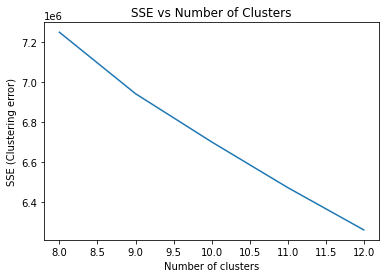

In [ ]:

# Calculate SSE for different number of clusters
sse = []
for n_clusters in range(8, 13):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

# Plot SSE against number of clusters
plt.plot(range(8, 13), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Clustering error)')
plt.title('SSE vs Number of Clusters')
plt.show()

Number of Clusters: 8, Clustering Error: 340308.10
Number of Clusters: 9, Clustering Error: 334829.57
Number of Clusters: 10, Clustering Error: 329712.78
Number of Clusters: 11, Clustering Error: 325561.76
Number of Clusters: 12, Clustering Error: 321411.05


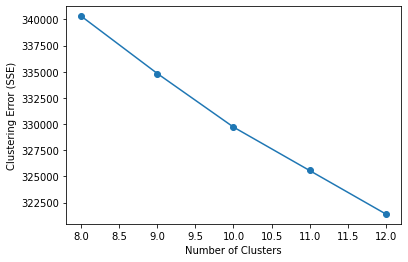

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion-MNIST dataset
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
def kmeans_clustering(data, num_clusters, max_iterations=100):
    # Initialize cluster centers randomly
    indices = np.random.choice(data.shape[0], num_clusters, replace=False)
    centers = data[indices]
    for i in range(max_iterations):
        # Assign each data point to the nearest cluster center
        distances = torch.cdist(data, centers)
        assignments = torch.argmin(distances, dim=1)
        # Update cluster centers
        for j in range(num_clusters):
            mask = (assignments == j)
            if torch.sum(mask) > 0:
                centers[j] = torch.mean(data[mask], dim=0)
    # Compute clustering error (SSE)
    distances = torch.cdist(data, centers)
    errors = torch.sum(torch.min(distances, dim=1)[0])
    return errors.item()

num_clusters_list = [8, 9, 10, 11, 12]
sse_list = []
for num_clusters in num_clusters_list:
    sse = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.shape[0], -1)
        sse += kmeans_clustering(data, num_clusters)
    sse_list.append(sse)
    print(f"Number of Clusters: {num_clusters}, Clustering Error: {sse:.2f}")

plt.plot(num_clusters_list, sse_list, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Error (SSE)')
plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Epoch [1/10], Loss: 0.0192
Epoch [2/10], Loss: 0.0152
Epoch [3/10], Loss: 0.0143
Epoch [4/10], Loss: 0.0135
Epoch [5/10], Loss: 0.0166
Epoch [6/10], Loss: 0.0208
Epoch [7/10], Loss: 0.0130
Epoch [8/10], Loss: 0.0136
Epoch [9/10], Loss: 0.0150
Epoch [10/10], Loss: 0.0140


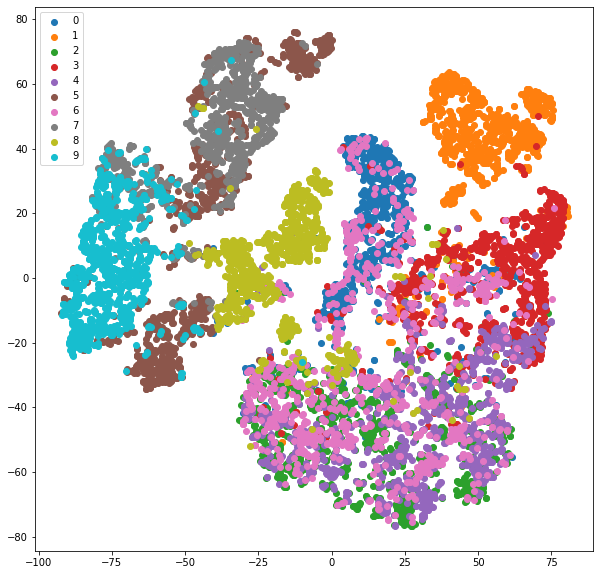

In [ ]:
# 1.7 
# Repeat the autoencoder steps with a nonlinear autoencoder and compare the results against PCA and linear encoder.

!pip install torch numpy matplotlib sklearn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
transform = transforms.Compose([transforms.ToTensor()])

trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
class NonlinearAutoencoder(torch.nn.Module):
    def __init__(self):
        super(NonlinearAutoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

nonlinear_autoencoder = NonlinearAutoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nonlinear_autoencoder.parameters(), lr=0.001)

for epoch in range(10):
    for data in trainloader:
        img, _ = data
        optimizer.zero_grad()
        output = nonlinear_autoencoder(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

hidden_representations = []
labels = []

for data in testloader:
    img, label = data
    output = autoencoder.encoder(img.view(-1, 28 * 28))
    hidden_representations.append(output.detach().numpy())
    labels.append(label.numpy())

hidden_representations = np.concatenate(hidden_representations, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2)
hidden_tsne = tsne.fit_transform(hidden_representations)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(hidden_tsne[labels == i, 0], hidden_tsne[labels == i, 1], label=str(i))
plt.legend()
plt.show()


[1,   100] loss: 0.149
[1,   200] loss: 0.096
[1,   300] loss: 0.078
[1,   400] loss: 0.067
[1,   500] loss: 0.061
[1,   600] loss: 0.056
[1,   700] loss: 0.053
[1,   800] loss: 0.051
[1,   900] loss: 0.049
[1,  1000] loss: 0.049
[1,  1100] loss: 0.046
[1,  1200] loss: 0.046
[1,  1300] loss: 0.046
[1,  1400] loss: 0.045
[1,  1500] loss: 0.045
[1,  1600] loss: 0.044
[1,  1700] loss: 0.044
[1,  1800] loss: 0.044
[2,   100] loss: 0.042
[2,   200] loss: 0.042
[2,   300] loss: 0.041
[2,   400] loss: 0.041
[2,   500] loss: 0.041
[2,   600] loss: 0.040
[2,   700] loss: 0.039
[2,   800] loss: 0.039
[2,   900] loss: 0.038
[2,  1000] loss: 0.038
[2,  1100] loss: 0.037
[2,  1200] loss: 0.037
[2,  1300] loss: 0.037
[2,  1400] loss: 0.036
[2,  1500] loss: 0.036
[2,  1600] loss: 0.036
[2,  1700] loss: 0.035
[2,  1800] loss: 0.035
[3,   100] loss: 0.035
[3,   200] loss: 0.035
[3,   300] loss: 0.035
[3,   400] loss: 0.035
[3,   500] loss: 0.034
[3,   600] loss: 0.034
[3,   700] loss: 0.034
[3,   800] 

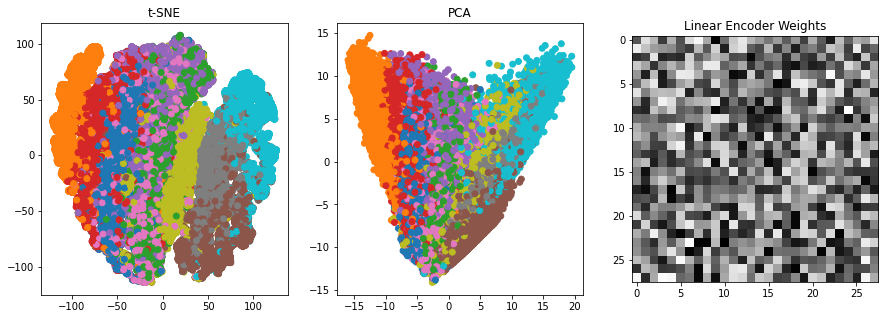

In [8]:
# 1.7 
# Repeat the autoencoder steps with a nonlinear autoencoder and compare the results against PCA and linear encoder.

import torch
import torch.nn as nn
import torchvision
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the Fashion-MNIST dataset
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the nonlinear encoder model
class NonlinearEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train the nonlinear encoder model
input_size = 28 * 28  # size of each Fashion-MNIST image
hidden_size = 8
model = NonlinearEncoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(train_loader, 0):
        inputs = inputs.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Get the hidden representations of the Fashion-MNIST data
hidden_embeddings = []
labels = []
for images, targets in train_loader:
    images = images.view(-1, input_size)
    embeddings = model.encoder(images).detach().numpy()
    hidden_embeddings.append(embeddings)
    labels.append(targets.numpy())
hidden_embeddings = np.vstack(hidden_embeddings)
labels = np.concatenate(labels)

# Visualize the Fashion-MNIST data in the hidden space using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(hidden_embeddings)

# Perform PCA on the Fashion-MNIST data
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(hidden_embeddings)

# Get the weights of the linear encoder
linear_weights = model.encoder[0].weight.detach().numpy()

# Plot the visualizations
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='tab10')
axs[0].set_title('t-SNE')
axs[1].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=labels, cmap='tab10')
axs[1].set_title('PCA')
for i in range(8):
    axs[2].imshow(linear_weights[i].reshape(28, 28), cmap='gray')
    axs[2].set_title('Linear Encoder Weights')
plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=617a695c855c2ed9b061ca4e8b3799545c53091886c7b0300e35d5ec07757ad3
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
Epoch [1/10], Loss: 0.0236
Epoch [2/10], Loss: 0.0195
Epoch [3/10], Loss: 0.0132
Epoch [4/10], Loss: 0.0163
Epoch [5/10], Loss: 0.0171
Epoch [6/10], Loss: 0.0137
Epoch [7/10], Loss: 0.0163
Epoch [8/10], Loss: 0.0139
Epoch [9/10], Loss: 0.0159
Epoch [10/10], Loss: 0.0131


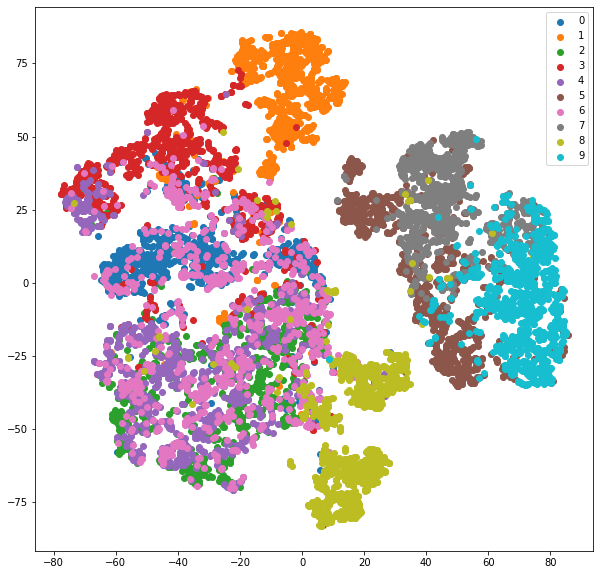

In [7]:
# 1.6
# Using t-SNE, visualize the Fashion-MNIST data in the autoencoder’s hidden space.

!pip install torch numpy matplotlib sklearn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
transform = transforms.Compose([transforms.ToTensor()])

trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

autoencoder = Autoencoder()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(10):
    for data in trainloader:
        img, _ = data
        optimizer.zero_grad()
        output = autoencoder(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

hidden_representations = []
labels = []

for data in testloader:
    img, label = data
    output = autoencoder.encoder(img.view(-1, 28 * 28))
    hidden_representations.append(output.detach().numpy())
    labels.append(label.numpy())

hidden_representations = np.concatenate(hidden_representations, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2)
hidden_tsne = tsne.fit_transform(hidden_representations)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(hidden_tsne[labels == i, 0], hidden_tsne[labels == i, 1], label=str(i))
plt.legend()
plt.show()



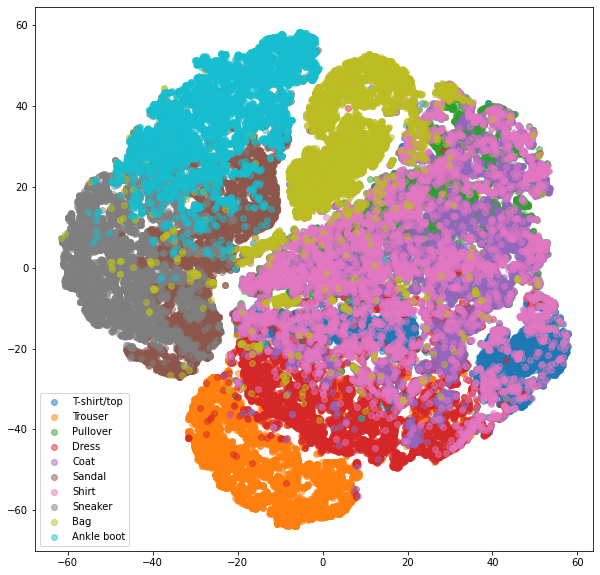

In [9]:
# 1.6
# PCA visualization

import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

from sklearn.decomposition import PCA

def perform_pca(data, k=8):
    # Flatten the data to a 2D array
    flat_data = data.reshape(data.shape[0], -1)
    
    # Fit PCA to the flattened data
    pca = PCA(n_components=k)
    pca.fit(flat_data)
    
    # Return the top k eigenvectors
    return pca.components_


eigenvectors = perform_pca(train_set.data, k=8)

import numpy as np

# Flatten the data
flat_data = train_set.data.reshape(train_set.data.shape[0], -1)

# Compute the projection
projection = np.dot(flat_data, eigenvectors.T)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
embedded = tsne.fit_transform(projection)

import matplotlib.pyplot as plt

# Define the classes
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 
    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Create a scatter plot
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    x = embedded[train_set.targets == i, 0]
    y = embedded[train_set.targets == i, 1]
    plt.scatter(x, y, label=classes[i], alpha=0.5)

plt.legend()
plt.show()



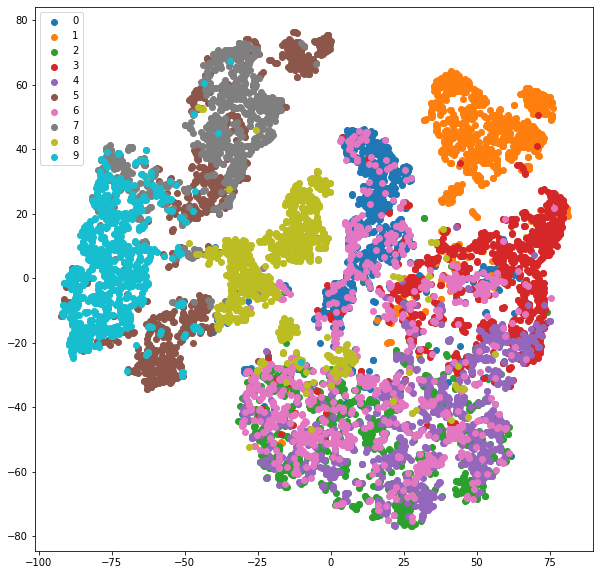

In [ ]:
'''hidden_representations = []
labels = []

for data in testloader:
    img, label = data
    output = autoencoder.encoder(img.view(-1, 28 * 28))
    hidden_representations.append(output.detach().numpy())
    labels.append(label.numpy())

hidden_representations = np.concatenate(hidden_representations, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2)
hidden_tsne = tsne.fit_transform(hidden_representations)
'''
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(hidden_tsne[labels == i, 0], hidden_tsne[labels == i, 1], label=str(i))
plt.legend()
plt.show()


Epoch [1/50], Loss: 0.0656
Epoch [2/50], Loss: 0.0501
Epoch [3/50], Loss: 0.0493
Epoch [4/50], Loss: 0.0471
Epoch [5/50], Loss: 0.0416
Epoch [6/50], Loss: 0.0397
Epoch [7/50], Loss: 0.0412
Epoch [8/50], Loss: 0.0369
Epoch [9/50], Loss: 0.0352
Epoch [10/50], Loss: 0.0339
Epoch [11/50], Loss: 0.0362
Epoch [12/50], Loss: 0.0363
Epoch [13/50], Loss: 0.0393
Epoch [14/50], Loss: 0.0330
Epoch [15/50], Loss: 0.0375
Epoch [16/50], Loss: 0.0343
Epoch [17/50], Loss: 0.0345
Epoch [18/50], Loss: 0.0363
Epoch [19/50], Loss: 0.0340
Epoch [20/50], Loss: 0.0335
Epoch [21/50], Loss: 0.0350
Epoch [22/50], Loss: 0.0356
Epoch [23/50], Loss: 0.0346
Epoch [24/50], Loss: 0.0355
Epoch [25/50], Loss: 0.0356
Epoch [26/50], Loss: 0.0348
Epoch [27/50], Loss: 0.0326
Epoch [28/50], Loss: 0.0335
Epoch [29/50], Loss: 0.0333
Epoch [30/50], Loss: 0.0328
Epoch [31/50], Loss: 0.0350
Epoch [32/50], Loss: 0.0366
Epoch [33/50], Loss: 0.0357
Epoch [34/50], Loss: 0.0355
Epoch [35/50], Loss: 0.0336
Epoch [36/50], Loss: 0.0321
E

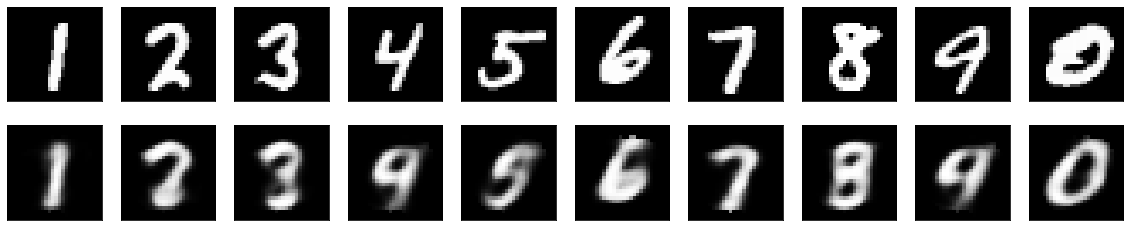

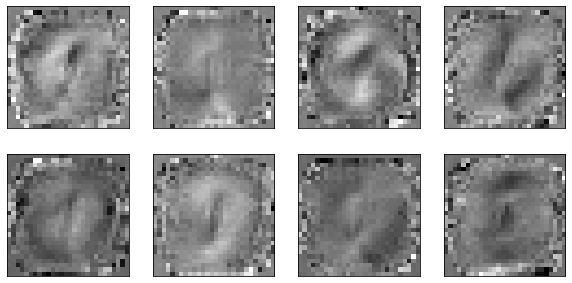

In [ ]:
# 1.5
# Visualize the input weight matrix again in the form of 8 images. Compare these with 8 PCA based eigen images and give your comments.

import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

# Define the linear encoder model with one hidden layer of 8 neurons
class LinearEncoder(nn.Module):
    def __init__(self):
        super(LinearEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Define the optimization algorithm and loss function
model = LinearEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model for 50 epochs on the training set
for epoch in range(50):
    for images, _ in train_loader:
        images = images.view(-1, 784)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 50, loss.item()))

# Generate reconstructed images using the trained model
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        reconstructed_images = outputs.detach().numpy()

# Plot a few original and reconstructed images side by side for comparison
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].view(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Extract the weight matrix of the first layer
encoder_weights = model.encoder[0].weight.detach().numpy()

# Reshape each row into a 28x28 image and plot the resulting images
plt.figure(figsize=(10, 5))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(encoder_weights[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


[1,   100] loss: 0.213
[1,   200] loss: 0.132
[1,   300] loss: 0.086
[1,   400] loss: 0.074
[1,   500] loss: 0.068
[1,   600] loss: 0.067
[1,   700] loss: 0.066
[1,   800] loss: 0.065
[1,   900] loss: 0.064
[1,  1000] loss: 0.064
[1,  1100] loss: 0.064
[1,  1200] loss: 0.063
[1,  1300] loss: 0.064
[1,  1400] loss: 0.063
[1,  1500] loss: 0.062
[1,  1600] loss: 0.062
[1,  1700] loss: 0.061
[1,  1800] loss: 0.062
[2,   100] loss: 0.062
[2,   200] loss: 0.063
[2,   300] loss: 0.061
[2,   400] loss: 0.062
[2,   500] loss: 0.061
[2,   600] loss: 0.062
[2,   700] loss: 0.062
[2,   800] loss: 0.062
[2,   900] loss: 0.062
[2,  1000] loss: 0.062
[2,  1100] loss: 0.062
[2,  1200] loss: 0.062
[2,  1300] loss: 0.062
[2,  1400] loss: 0.062
[2,  1500] loss: 0.062
[2,  1600] loss: 0.062
[2,  1700] loss: 0.061
[2,  1800] loss: 0.063
[3,   100] loss: 0.062
[3,   200] loss: 0.062
[3,   300] loss: 0.062
[3,   400] loss: 0.061
[3,   500] loss: 0.063
[3,   600] loss: 0.061
[3,   700] loss: 0.062
[3,   800] 

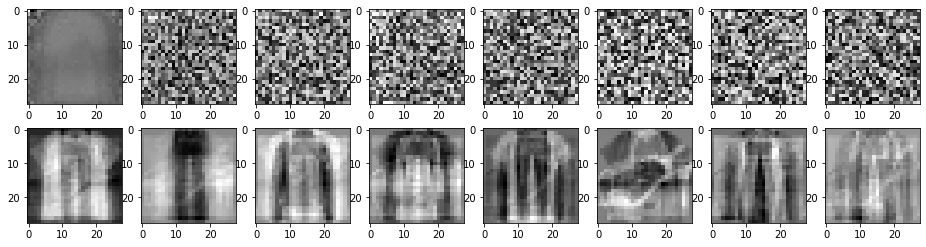

In [6]:
# 1.5
# Visualize the input weight matrix again in the form of 8 images. Compare these with 8 PCA based eigen images and give your comments.

import torch
import torch.nn as nn
import torchvision
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the Fashion-MNIST dataset
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the linear encoder model
class LinearEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        return x

# Train the linear encoder model
input_size = 28 * 28  # size of each Fashion-MNIST image
hidden_size = 8
model = LinearEncoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(train_loader, 0):
        inputs = inputs.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Get the weights of the hidden layer
hidden_weights = model.encoder.weight.detach().numpy()

# Perform PCA on the Fashion-MNIST data
pca = PCA(n_components=8)
images, _ = next(iter(train_loader))
images = images.view(-1, input_size).numpy()
pca.fit(images)
pca_weights = pca.components_

# Plot the weight matrices as images
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(hidden_weights[i].reshape(28, 28), cmap='gray')
    axs[1, i].imshow(pca_weights[i].reshape(28, 28), cmap='gray')
plt.show()


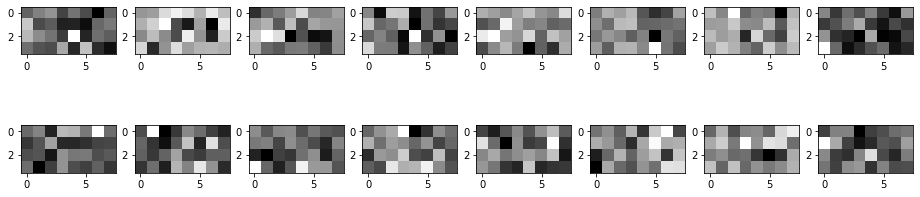

In [5]:
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define the linear encoder model
class LinearEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        return x

# Generate some random data
input_data = torch.randn(100, 32)

# Train the linear encoder model
model = LinearEncoder(input_size=32, hidden_size=8)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(input_data)
    loss = criterion(outputs, input_data)
    loss.backward()
    optimizer.step()

# Get the weights of the hidden layer
hidden_weights = model.encoder.weight.detach().numpy()

# Perform PCA on the input data
pca = PCA(n_components=8)
pca.fit(input_data)
pca_weights = pca.components_

# Plot the weight matrices as images
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(hidden_weights[i].reshape(4, 8), cmap='gray')
    axs[1, i].imshow(pca_weights[i].reshape(4, 8), cmap='gray')
plt.show()


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/20], Loss: 0.0598
Epoch [2/20], Loss: 0.0529
Epoch [3/20], Loss: 0.0497
Epoch [4/20], Loss: 0.0444
Epoch [5/20], Loss: 0.0541
Epoch [6/20], Loss: 0.0452
Epoch [7/20], Loss: 0.0484
Epoch [8/20], Loss: 0.0472
Epoch [9/20], Loss: 0.0496
Epoch [10/20], Loss: 0.0430
Epoch [11/20], Loss: 0.0460
Epoch [12/20], Loss: 0.0465
Epoch [13/20], Loss: 0.0485
Epoch [14/20], Loss: 0.0484
Epoch [15/20], Loss: 0.0499
Epoch [16/20], Loss: 0.0470
Epoch [17/20], Loss: 0.0478
Epoch [18/20], Loss: 0.0436
Epoch [19/20], Loss: 0.0407
Epoch [20/20], Loss: 0.0429


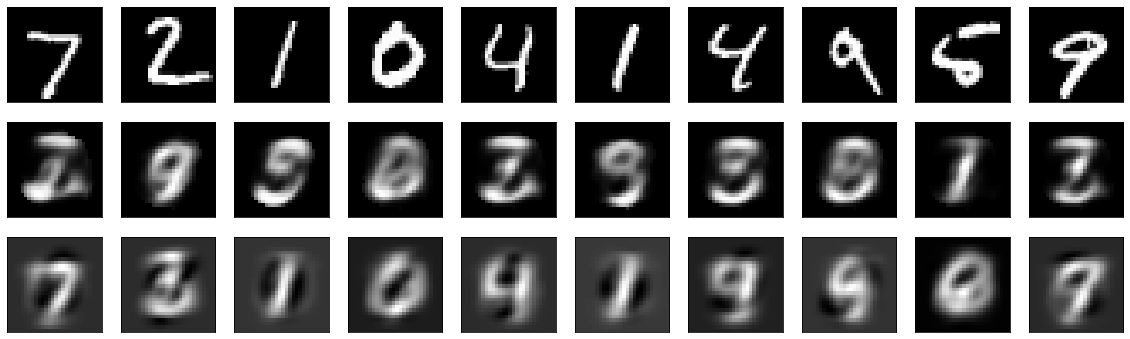

In [ ]:
# 1.4
# Implement a simple linear encoder with one hidden layer of 8 neurons and compare the reconstructed images with those done using PCA. 
# Provide comments on your results.

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

# Set device to use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transform to convert images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the encoder and decoder models
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 8),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(8, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        return encoded, decoded

# Initialize the model and define loss criterion and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        encoded, output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model on test data and compare with PCA
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Get the encoded and decoded images
with torch.no_grad():
    encoded_imgs = []
    decoded_imgs = []
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        encoded, decoded = model(img)
        encoded_imgs.append(encoded)
        decoded_imgs.append(decoded.cpu())

    encoded_imgs = torch.cat(encoded_imgs, dim=0).cpu().numpy()
    decoded_imgs = torch.cat(decoded_imgs, dim=0).numpy()

# Compare with PCA
train_data = train_dataset.data.numpy().reshape(len(train_dataset), -1)
test_data = test_dataset.data.numpy().reshape(len(test_dataset), -1)

pca = PCA(n_components=8)
pca.fit(train_data)
pca_encoded_imgs = pca.transform(test_data)
pca_decoded_imgs = pca.inverse_transform(pca_encoded_imgs)

# Plot the original, reconstructed and PCA reconstructed images
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed image using linear encoder
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed image using PCA
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(pca_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



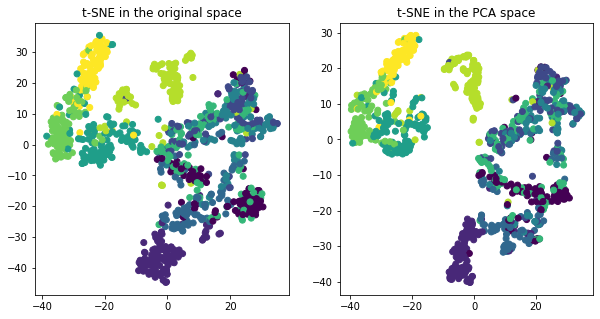

In [ ]:
# 1.3 
# Using t-SNE, visualize the Fashion-MNIST data in the original space and in the PCA space consisting of top 8 eigen images.

import torch
import torchvision
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load Fashion-MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)

# Extract images and labels from the dataset
images, labels = next(iter(trainloader))

# Flatten the images into 1D tensors
images = images.view(images.shape[0], -1)

# Compute PCA
pca = PCA(n_components=8)
pca.fit(images)

# Transform the images into PCA space
pca_images = pca.transform(images)

# Compute t-SNE in the original space
tsne_orig = TSNE(n_components=2, random_state=0)
tsne_orig_results = tsne_orig.fit_transform(images)

# Compute t-SNE in the PCA space
tsne_pca = TSNE(n_components=2, random_state=0)
tsne_pca_results = tsne_pca.fit_transform(pca_images)

# Visualize t-SNE in the original space
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_orig_results[:, 0], tsne_orig_results[:, 1], c=labels)
plt.title('t-SNE in the original space')

# Visualize t-SNE in the PCA space
plt.subplot(1, 2, 2)
plt.scatter(tsne_pca_results[:, 0], tsne_pca_results[:, 1], c=labels)
plt.title('t-SNE in the PCA space')

plt.show()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



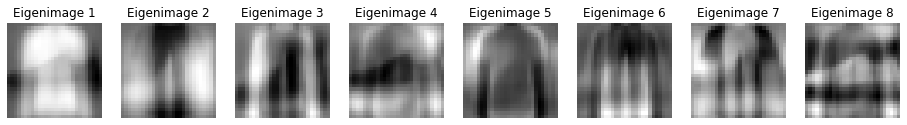

In [ ]:
# 1.2
# Generate 10 reconstructed images, one for each class. This will be done by using the top 8 eigen values/vectors. 
# Calculate the error between the original and the reconstructed images.

import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

data = trainset.data.numpy()
data = data.reshape(data.shape[0], -1)

data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_norm = (data - data_mean) / data_std

pca = PCA(n_components=8)
pca.fit(data_norm)
eigenimages = pca.components_.reshape(8, 28, 28)

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i in range(8):
    axs[i].imshow(eigenimages[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Eigenimage {i+1}')
plt.show()


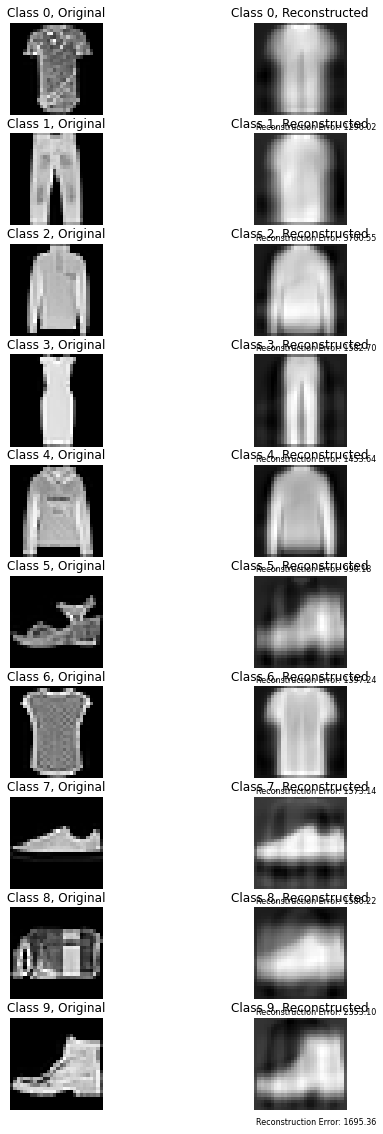

In [ ]:
## 1.1
## Perform PCA on Fashion-MNIST data and visualize first 8 eigen images resulting from PCA.

import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

data = trainset.data.numpy()
data = data.reshape(data.shape[0], -1)

data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_norm = (data - data_mean) / data_std

pca = PCA(n_components=8)
pca.fit(data_norm)
eigenvectors = pca.components_.T

fig, axs = plt.subplots(10, 2, figsize=(8, 20))
for i in range(10):
    # select a random image from the i-th class
    class_data = data_norm[trainset.targets == i]
    random_idx = np.random.choice(class_data.shape[0])
    image = class_data[random_idx]

    # reconstruct the image using the top 8 eigenvectors
    coeffs = np.dot(eigenvectors.T, image)
    reconstructed_image = np.dot(eigenvectors, coeffs)

    # denormalize the original and reconstructed images
    original_image = (image * data_std) + data_mean
    reconstructed_image = (reconstructed_image * data_std) + data_mean

    # calculate the error between the original and reconstructed images
    error = np.mean((original_image - reconstructed_image) ** 2)

    # plot the original and reconstructed images side by side
    axs[i, 0].imshow(original_image.reshape(28, 28), cmap='gray')
    axs[i, 0].set_title(f'Class {i}, Original')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    axs[i, 1].set_title(f'Class {i}, Reconstructed')
    axs[i, 1].axis('off')
    axs[i, 1].text(0, 32, f'Reconstruction Error: {error:.2f}', fontsize=8)
plt.show()





  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



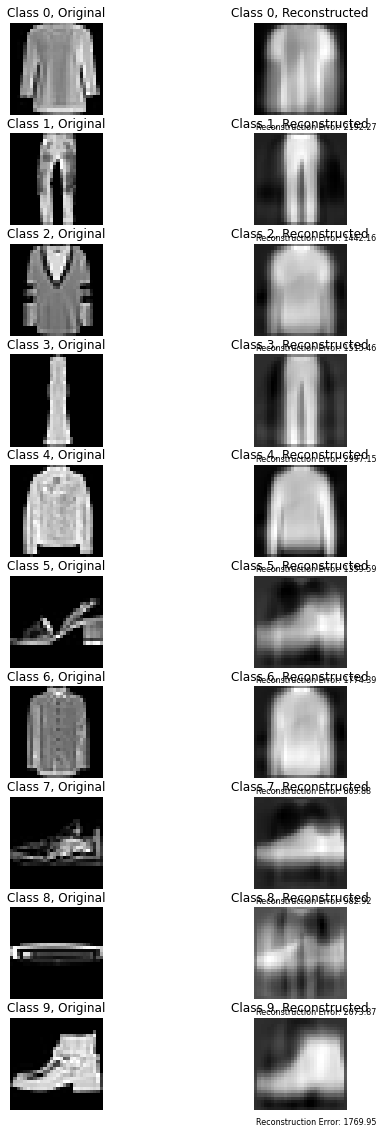

In [2]:
## 1.1
## Perform PCA on Fashion-MNIST data and visualize first 8 eigen images resulting from PCA.

import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

data = trainset.data.numpy()
data = data.reshape(data.shape[0], -1)

data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_norm = (data - data_mean) / data_std

pca = PCA(n_components=8)
pca.fit(data_norm)
eigenvectors = pca.components_.T

'''fig, axs = plt.subplots(10, 2, figsize=(8, 20))
for i in range(10):
    # select a random image from the i-th class
    class_data = data_norm[trainset.targets == i]
    random_idx = np.random.choice(class_data.shape[0])
    image = class_data[random_idx]

    # reconstruct the image using the top 8 eigenvectors
    coeffs = np.dot(eigenvectors.T, image)
    reconstructed_image = np.dot(eigenvectors, coeffs)

    # denormalize the original and reconstructed images
    original_image = (image * data_std) + data_mean
    reconstructed_image = (reconstructed_image * data_std) + data_mean

    # calculate the error between the original and reconstructed images
    error = np.mean((original_image - reconstructed_image) ** 2)

    # plot the original and reconstructed images side by side
    axs[i, 0].imshow(original_image.reshape(28, 28), cmap='gray')
    axs[i, 0].set_title(f'Class {i}, Original')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    axs[i, 1].set_title(f'Class {i}, Reconstructed')
    axs[i, 1].axis('off')
    axs[i, 1].text(0, 32, f'Reconstruction Error: {error:.2f}', fontsize=8)
plt.show()'''


fig, axs = plt.subplots(10, 2, figsize=(8, 20))
for i in range(10):
    # select a random image from the i-th class
    class_data = data_norm[trainset.targets == i]
    random_idx = np.random.choice(class_data.shape[0])
    image = class_data[random_idx]

    # reconstruct the image using the top 8 eigenvectors
    coeffs = np.dot(eigenvectors.T, image)
    reconstructed_image = np.dot(eigenvectors, coeffs)

    # denormalize the original and reconstructed images
    original_image = (image * data_std) + data_mean
    reconstructed_image = (reconstructed_image * data_std) + data_mean

    # calculate the error between the original and reconstructed images
    error = np.mean((original_image - reconstructed_image) ** 2)

    # plot the original and reconstructed images side by side
    axs[i, 0].imshow(original_image.reshape(28, 28), cmap='gray')
    axs[i, 0].set_title(f'Class {i}, Original')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    axs[i, 1].set_title(f'Class {i}, Reconstructed')
    axs[i, 1].axis('off')
    axs[i, 1].text(0, 32, f'Reconstruction Error: {error:.2f}', fontsize=8)
plt.show()



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



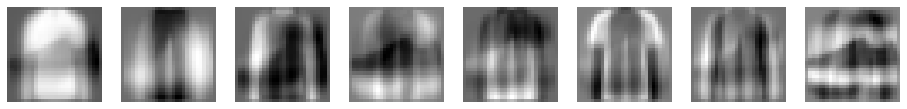

In [1]:
import torch
import torchvision
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

# Flatten the images
X = next(iter(train_loader))[0].view(len(train_dataset), -1).numpy()

# Perform PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

# Reshape the first 8 eigenvectors as images
eigenimages = pca.components_[:8].reshape(-1, 28, 28)

# Plot the eigenimages horizontally
fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i in range(8):
    axs[i].imshow(eigenimages[i], cmap='gray')
    axs[i].axis('off')
plt.show()


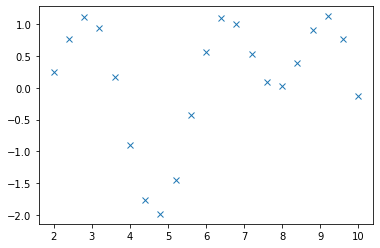

Epoch: 0 loss 4.97376823425293
Epoch: 10 loss 0.1292264312505722
Epoch: 20 loss 0.13346834480762482
Epoch: 30 loss 0.11808225512504578
Epoch: 40 loss 0.09804810583591461
Epoch: 50 loss 0.07966528832912445
Epoch: 60 loss 0.0642784908413887
Epoch: 70 loss 0.0514116995036602
Epoch: 80 loss 0.04127122089266777
Epoch: 90 loss 0.03391854837536812
Epoch: 100 loss 0.029065746814012527
Epoch: 110 loss 0.026722557842731476
Epoch: 120 loss 0.027391662821173668
Epoch: 130 loss 0.03189334273338318
Epoch: 140 loss 0.04148048162460327
Epoch: 150 loss 0.049229271709918976
Epoch: 160 loss 0.04620499163866043
Epoch: 170 loss 0.042906805872917175
Epoch: 180 loss 0.04358595609664917
Epoch: 190 loss 0.04912036284804344
Epoch: 200 loss 0.08260169625282288
Epoch: 210 loss 0.1054549515247345
Epoch: 220 loss 0.10679711401462555
Epoch: 230 loss 0.1182253509759903
Epoch: 240 loss 0.10493342578411102
Epoch: 250 loss 0.08134005963802338
Epoch: 260 loss 0.0743773803114891
Epoch: 270 loss 0.09669937938451767
Epoch: 

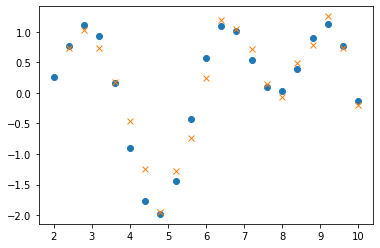

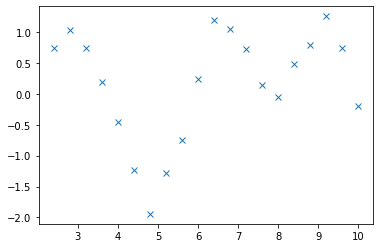

[tensor([[ 0.9118,  0.9795, -0.9542,  0.5342],
        [ 0.0274,  0.1297,  0.1548,  0.6643]], grad_fn=<TanhBackward0>), tensor([[ 0.8760,  0.3820,  0.5361, -0.5886],
        [-0.8365,  0.1957, -0.3409,  0.1116]], grad_fn=<TanhBackward0>), tensor([[-0.7127,  0.2445, -0.0142,  0.5310],
        [ 0.6032,  0.8205, -0.4138, -0.3292]], grad_fn=<TanhBackward0>)]
tensor([[[ 2.0706,  1.6779,  0.7329],
         [-1.2198, -0.1040,  0.4893]],

        [[ 1.9922,  1.1682,  1.6492],
         [ 0.1785,  1.1224, -1.0030]],

        [[-0.3848,  0.5853, -0.8005],
         [ 0.7216,  1.2969,  1.9522]]])


In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
dtype = torch.FloatTensor
input_size, hidden_size, output_size = 9, 8, 1
epochs = 300
seq_length = 20
lr = 0.1
data_time_steps = np.linspace(2, 10, seq_length + 1)
data = np.sin(data_time_steps)+np.cos(data_time_steps*2)
data.resize((seq_length + 1, 1))
plt.plot(data_time_steps,data,'x')
plt.show()
 
x = Variable(torch.Tensor(data[:-1]).type(dtype), requires_grad=False)
y = Variable(torch.Tensor(data[1:]).type(dtype), requires_grad=False)

w1 = torch.FloatTensor(input_size, hidden_size).type(dtype)
init.normal_(w1, 0.0, 0.4)
w1 =  Variable(w1, requires_grad=True)
w2 = torch.FloatTensor(hidden_size, output_size).type(dtype)
init.normal_(w2, 0.0, 0.3)
w2 = Variable(w2, requires_grad=True)
def forward(x, hidden_state, w1, w2):
  xh = torch.cat((input, hidden_state), 1)
  hidden_state = torch.tanh(xh.mm(w1))
  out = hidden_state.mm(w2)
  return  (out, hidden_state)
for i in range(epochs):
  total_loss = 0
  hidden_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad=True)
  for j in range(x.size(0)):
    input = x[j:(j+1)]
    target = y[j:(j+1)]
    (pred, hidden_state) = forward(x, hidden_state, w1, w2)
    loss = (pred - target).pow(2).sum()/2
    total_loss += loss
    loss.backward()
    w1.data -= lr * w1.grad.data
    w2.data -= lr * w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    hidden_state = Variable(hidden_state.data)
  if i % 10 == 0:
     print("Epoch: {} loss {}".format(i, total_loss.item()))

hidden_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad=False)
predictions = []
 
for i in range(x.size(0)):
  input = x[i:i+1]
  (pred, hidden_state) = forward(x, hidden_state, w1, w2)
  hidden_state = hidden_state
  input = pred
  predictions.append(pred.data.numpy().ravel()[0])
plt.plot(data_time_steps,data,'o',data_time_steps[1:21],predictions,'x')#'r-o' will give red dots
plt.show()# Predicted values should be shifted by one time unit

plt.plot(data_time_steps[1:21],predictions,'x')
plt.show()

input_size = 3
hidden_size = 4
Seq_length = 2
Numb_batches = 3
rnn = nn.RNNCell(input_size, hidden_size)#torch.RNNCell accepts a tensor as input,
#as well as the previous hidden states, and outputs
#the next hidden state for each element in the batch.
input = torch.randn(Numb_batches,Seq_length, input_size)
hx = torch.randn(Seq_length, hidden_size)
output = []
for i in range(Numb_batches):
        hx = rnn(input[i], hx)
        output.append(hx)
print(output)

print(input)


In [ ]:
# vanill RNN to predict next letter
import torch
from torch import nn
import numpy as np
## First, let's define the sentences that we want our model to output when fed with the first word or the first few characters. Then we'll create a dictionary out of all the characters that we have in the sentences and map them to an integer. This will allow us to convert our input characters to their respective integers (char2int) and vice versa (int2char).

text = ['hi how are you','i am good','have a nice day']
# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))
# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}
print(char2int)
## {'e': 0, 'r': 1, 'c': 2, 'w': 3, ' ': 4, 'y': 5, 'a': 6, 'd': 7, 'g': 8, 'm': 9, 'o': 10, 'h': 11, 'u': 12, 'v': 13, 'i': 14, 'n': 15}
## We will be padding input sentences to make all sentences of same length. This will allow us to input data in batches. The padding will be white spaces

# Finding the length of the longest string in our data
maxlen = len(max(text, key=len))

# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of
# the sentence matches the length of the longest sentence
for i in range(len(text)):
  while len(text[i])<maxlen:
      text[i] += ' '
## Now, lets prepare input/output data for training. Since we want to predict the next character in the sequence at each time step, we'll divide each sentence into: Input data where the last input character should be excluded as it does not need to be fed into the model. For Target/Ground Truth Label, we will prepare it with one time-step ahead of the Input data as this will be the "correct answer" for the model at each time step corresponding to the input data

# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
  input_seq.append(text[i][:-1])
    
    # Remove first character for target sequence
  target_seq.append(text[i][1:])
  print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

# Now we convert text to integers for one-hot coding
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]
# Set some parameters
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features
# Input shape --> (Batch Size, Sequence Length, One-Hot Encoding Size)
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
#Now convert to tensors
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)
# Now we define our network
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)

# Define hyperparameters
n_epochs = 200
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

#Testing the mode by inputting a sequence
# This function takes in the model and character as arguments and returns the next character prediction and hidden state
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden
# This function takes the desired output length and input characters as arguments, returning the produced sentence
def sample(model, out_len, start='hi'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)
sample(model, 12, 'have')

{'d': 0, 'c': 1, 'w': 2, 'n': 3, 'i': 4, 'o': 5, 'y': 6, 'u': 7, 'm': 8, 'g': 9, 'a': 10, 'r': 11, 'e': 12, ' ': 13, 'h': 14, 'v': 15}
Input Sequence: hi how are you
Target Sequence: i how are you 
Input Sequence: i am good     
Target Sequence:  am good      
Input Sequence: have a nice da
Target Sequence: ave a nice day
Epoch: 10/200............. Loss: 2.2557
Epoch: 20/200............. Loss: 2.0990
Epoch: 30/200............. Loss: 1.8545
Epoch: 40/200............. Loss: 1.5257
Epoch: 50/200............. Loss: 1.1594
Epoch: 60/200............. Loss: 0.8325
Epoch: 70/200............. Loss: 0.5762
Epoch: 80/200............. Loss: 0.3915
Epoch: 90/200............. Loss: 0.2691
Epoch: 100/200............. Loss: 0.1930
Epoch: 110/200............. Loss: 0.1465
Epoch: 120/200............. Loss: 0.1174
Epoch: 130/200............. Loss: 0.0987
Epoch: 140/200............. Loss: 0.0861
Epoch: 150/200............. Loss: 0.0772
Epoch: 160/200............. Loss: 0.0707
Epoch: 170/200............. L

'have a nice '